In [349]:
import utils
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import Conv1D, MaxPool1D, Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape, TimeDistributed, Input, GRU, Bidirectional
from keras.utils import to_categorical
import matplotlib.pyplot as plt

In [350]:
# Load the Dataset

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

y_train_valid -= 769
y_test -= 769


(2115, 22, 1000)


In [351]:
ind_valid = np.random.choice(2115, 200, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))
(x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid]
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]

# Shuffle the data after adding the noise to them so that the noisy examples 
# are not all together
x_train, y_train = utils.addNoisyExamplesToData(x_train, y_train, 6000, 0, 1)

indices = np.random.permutation(len(x_train))
x_train = x_train[indices]
y_train = y_train[indices]
print(x_train.shape)
print(y_train.shape)

y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)

# Reshape so that each example is three-dimensional 
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_valid.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# Axis swapping
x_train = np.swapaxes(x_train, 1, 3)
x_train = np.swapaxes(x_train, 1, 2)
x_valid = np.swapaxes(x_valid, 1, 3)
x_valid = np.swapaxes(x_valid, 1, 2)
X_test = np.swapaxes(X_test, 1, 3)
X_test = np.swapaxes(X_test, 1, 2)

x_train = x_train[:, 0:600, :, :]
x_valid = x_valid[:, 0:600, :, :]
X_test = X_test[:, 0:600, :, :]
print(x_train.shape)

(7915, 22, 1000)
(7915,)
(7915, 600, 1, 22)


In [394]:
hybrid_model = Sequential()

# Given that this is time-series data, having a kernel that is more along one dimension (e.g. 15 by 1) is reasonable
# since there is not really much of a relationship between "square" tiles of the data but rather subsequent 
# tiles
hybrid_model.add(Conv2D(filters=10, kernel_size=(15, 1), padding='same', activation='relu', input_shape=(600, 1, 22)))
hybrid_model.add(MaxPooling2D(pool_size=(3, 1), padding='same'))
hybrid_model.add(BatchNormalization())
hybrid_model.add(Dropout(0.4))

hybrid_model.add(Conv2D(filters=20, kernel_size=(10, 1), padding='same', activation='relu'))
hybrid_model.add(MaxPooling2D(pool_size=(3, 1), padding='same'))
hybrid_model.add(BatchNormalization())
hybrid_model.add(Dropout(0.4))

hybrid_model.add(Conv2D(filters=40, kernel_size=(5, 1), padding='same', activation='relu'))
hybrid_model.add(MaxPooling2D(pool_size=(3, 1), padding='same'))
hybrid_model.add(BatchNormalization())
hybrid_model.add(Dropout(0.4))

hybrid_model.add(Conv2D(filters=80, kernel_size=(5, 1), padding='same', activation='relu'))
hybrid_model.add(MaxPooling2D(pool_size=(3, 1), padding='same'))
hybrid_model.add(BatchNormalization())
hybrid_model.add(Dropout(0.4))


hybrid_model.add(TimeDistributed(Flatten()))
hybrid_model.add(TimeDistributed(Dense(40, activation='relu')))
hybrid_model.add(TimeDistributed(BatchNormalization()))
hybrid_model.add(TimeDistributed(Dropout(0.4)))

hybrid_model.add(GRU(8, dropout=0.4, recurrent_dropout=0.1, return_sequences=True))


hybrid_model.add(Flatten())
hybrid_model.add(Dense(4, activation='softmax'))

hybrid_model.summary()


Model: "sequential_136"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_426 (Conv2D)         (None, 600, 1, 10)        3310      
                                                                 
 max_pooling2d_418 (MaxPool  (None, 200, 1, 10)        0         
 ing2D)                                                          
                                                                 
 batch_normalization_522 (B  (None, 200, 1, 10)        40        
 atchNormalization)                                              
                                                                 
 dropout_522 (Dropout)       (None, 200, 1, 10)        0         
                                                                 
 conv2d_427 (Conv2D)         (None, 200, 1, 20)        2020      
                                                                 
 max_pooling2d_419 (MaxPool  (None, 67, 1, 20)      

In [395]:
learning_rate = 1e-3
epochs = 150
cnn_model_optimizer = keras.optimizers.legacy.Adam(learning_rate=learning_rate)

In [396]:
# Compiling the model
hybrid_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_model_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_model_results = hybrid_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)

Epoch 1/150
124/124 [==============================] - 5s 29ms/step - loss: 1.4985 - accuracy: 0.2587 - val_loss: 1.3539 - val_accuracy: 0.3550
Epoch 2/150
124/124 [==============================] - 3s 25ms/step - loss: 1.4090 - accuracy: 0.2934 - val_loss: 1.3532 - val_accuracy: 0.3350
Epoch 3/150
124/124 [==============================] - 3s 23ms/step - loss: 1.3725 - accuracy: 0.3179 - val_loss: 1.3579 - val_accuracy: 0.3350
Epoch 4/150
124/124 [==============================] - 3s 26ms/step - loss: 1.3381 - accuracy: 0.3491 - val_loss: 1.3386 - val_accuracy: 0.3300
Epoch 5/150
124/124 [==============================] - 3s 24ms/step - loss: 1.3117 - accuracy: 0.3742 - val_loss: 1.3205 - val_accuracy: 0.3450
Epoch 6/150
124/124 [==============================] - 3s 25ms/step - loss: 1.2737 - accuracy: 0.4019 - val_loss: 1.2914 - val_accuracy: 0.3650
Epoch 7/150
124/124 [==============================] - 3s 23ms/step - loss: 1.2473 - accuracy: 0.4267 - val_loss: 1.2485 - val_accuracy:

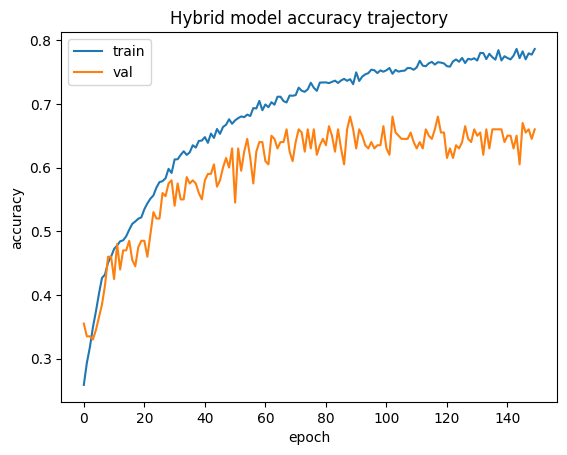

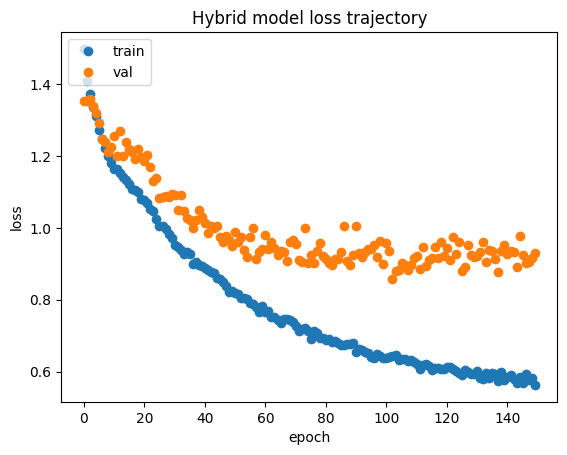

In [398]:
# Plotting accuracy trajectory
plt.plot(hybrid_model_results.history['accuracy'])
plt.plot(hybrid_model_results.history['val_accuracy'])
plt.title('Hybrid model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(hybrid_model_results.history['loss'],'o')
plt.plot(hybrid_model_results.history['val_loss'],'o')
plt.title('Hybrid model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [397]:
hybrid_model_score_all_subjects = hybrid_model.evaluate(X_test, y_test, verbose=0)
print("Accuracy Across All Subjects: {score}".format(score=hybrid_model_score_all_subjects[1]))

Accuracy Across All Subjects: 0.6749435663223267


In [399]:
# Test the model against each individual subject group
for i in range(9):
  indices = np.where(person_test[:, 0] == i)
  x = X_test[indices]
  y = y_test[indices]
  score = hybrid_model.evaluate(x, y, verbose=0)
  print("Subject {subject} Accuracy: {score}".format(subject=i, score=score[1]))

Subject 0 Accuracy: 0.6200000047683716
Subject 1 Accuracy: 0.5600000023841858
Subject 2 Accuracy: 0.7599999904632568
Subject 3 Accuracy: 0.6000000238418579
Subject 4 Accuracy: 0.7021276354789734
Subject 5 Accuracy: 0.6530612111091614
Subject 6 Accuracy: 0.699999988079071
Subject 7 Accuracy: 0.6800000071525574
Subject 8 Accuracy: 0.8085106611251831
